# Tutorial 0. Introduction

Welcome to the tutorial for cross decomposition analysis for neuroimaging in Python!
The objective of this first tutorial is to give an overview of the different algorithms allowing cross decomposition analysis.

But first, what does "cross decomposition analysis" mean?
Cross decomposition analyses look for relationships between different blocks of variables in order to make the most of all available information and make predictions about your data. These methods aim to reduce two distinct variable sets into a set of combined descriptors that may explain your data better than each of the variable sets alone. These methods are particularly used in neuroimaging to analyze associations between physiological/behavioral variables and brain structure/function.

Between unsupervised and supervised modeling, this methods has many variations. Here we will explore the most commonly used:
- Canonical correlation analysis (CCA)
- Partial Least Squares (PLS) canonical 
- PLS regression
- PLS Path Modeling (PLS-PM)

There are also some practicle considerations to take into account when selecting one of these models, this includes:
- data preprocessing (see Tutorial 1, *coming soon*)
- data reduction (see Tutorial 2, *coming soon*)
- model selection (see Tutorial 3, *coming soon*). 

In this introduction we will first go through each of the primary cross decomposition methods with example data in order to understand how these models differ from each other and which may be the most suited for a particular dataset or question. 

Before starting anything, we will first import (almost) all the librairies necessary for this tutorial.
Please note that Python 3.7.7. has been used for this tutorial and you need to have *numpy*, *matplotlib* and *sklearn* installed on your computer.

In [1]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
import matplotlib.pyplot as plt
import numpy as np

## Create data based on some latent variables


First we will create a simulated database to play with.
If you need any information for that step, please check [Tutorial 4](cca_data_simulation.ipynb) of this repository or this [tutorial](https://github.com/htwangtw/cca_primer/blob/master/cca_notebook.ipynb), explaining how to implement CCA in Python.

In [2]:
n = 100
# fix the random seed so this tutorial will always create the same results
np.random.seed(42)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents_x = np.array([l1, l2, l1, l1, l2, l2]).T
latents_y = np.array([l2, l2, l1, l1+l2]).T

X = latents_x + np.random.normal(size=6 * n).reshape((n, 6))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))

Let's divide this dataset into a train and a test set for this tutorial.

In [3]:
X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

## Define plot function

We will now define a plot function that allow to represent the X and Y scores of each component. 
The function comes from this [sklearn example](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_compare_cross_decomposition.html#sphx-glr-auto-examples-cross-decomposition-plot-compare-cross-decomposition-py).

In [4]:
def plot_scores(X_train_r, Y_train_r,
                X_test_r, Y_test_r):

    # 1) On diagonal plot X vs Y scores on each components
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 1")
    plt.ylabel("Y comp. 1")
    plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 2")
    plt.ylabel("Y comp. 2")
    plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    # 2) Off diagonal plot components 1 vs 2 for X and Y
    plt.subplot(222)
    plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("X comp. 1")
    plt.ylabel("X comp. 2")
    plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
              % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(223)
    plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("Y comp. 1")
    plt.ylabel("Y comp. 2")
    plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
              % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())
    plt.show()

## Canonical Correlation Analysis (CCA)

This method is useful for identifying the complex relationships between two high-dimensional sets of variables in large data sets. It simultanously evaluates two sets of variables without given preference or directionality to the relationship between these dimensions to identify common variation (using correlation) accross them (i.e there is no independent and dependent variable).  This produces several pairs of orthogonal canonical variables - canonical correlates - that each describe unique patterns of variables across the variable sets and allow more tangible interpretation of the data than non-orthogonal correlates. These canonical correlates can then be used to make new inferences about your data. This method is particularly suited for descriptive, unsupervised modeling. 

However this performs best under the following limiting conditions:
- there are more observations than variables - making it more suited to large datasets (in some cases data reduction can be used to a degree to help over come this (see Tutorial 2, *coming soon*))
- the data is normally distributed (if appropriate data can often be normalized during preprocessing (see Tutorial 1, *coming soon*)).
- Variables must display linear relationships

If these assumptions can’t be met then there are variations of CCA that can be applied such as kernel or deep CCA, sparse CCA, or probabilistic CCA. If you are interested in these alternatives, we would recommend the following article:

[Wang, H.-T., J. Smallwood, J. Mourao-Miranda, C. H. Xia, T. D. Satterthwaite, D. S. Bassett and D. Bzdok (2020). "Finding the needle in a high-dimensional haystack: Canonical correlation analysis for neuroscientists." NeuroImage](https://doi.org/10.1016/j.neuroimage.2020.116745)

The following code allows to train and transform the X and Y matrices.

In [5]:
# CCA (PLS mode B with symmetric deflation)

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = cca.transform(X_train, Y_train)
X_test_r, Y_test_r = cca.transform(X_test, Y_test)

The matrices obtained contain the scores of the latent variables for each sample.
We can now plot the results thanks to the plot function defined earlier.

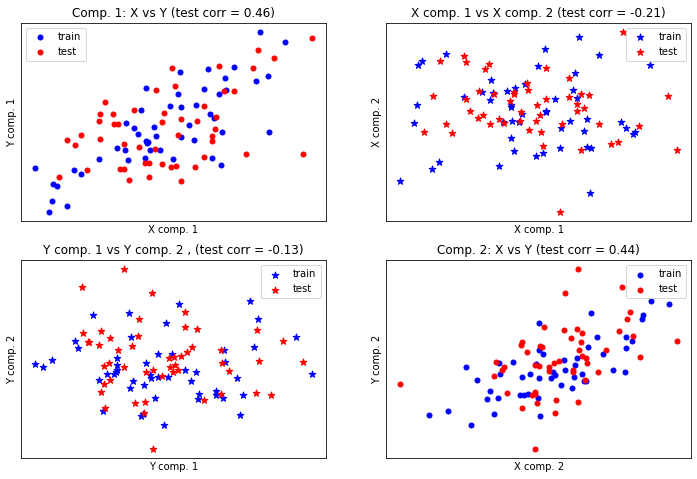

In [6]:
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

If the method has been successfully applied, the graphs comparing X vs. Y should be hightly correlated (i.e. *corr* close to 1) while in the other graphs, the data should show no correlation (i.e. *corr* close to 0, because the 2 components are orthogonal).

Great! You run your first CCA analysis! Let's have a look at what we call Partial Least Square (PLS) analysis now.


## Partial Least Square (PLS) Canonical

Often also refered to in the literature as PLS Correlation (PLSC). Part of the partial least squares family, this method maximises covariance over correlation but maintains the symmetry offered by CCA (i.e gives no preference to X or Y) between blocks of variables (unlike the other PLS methods). Similar to CCA, this method is suitable for high-dimensional collinear data however it may out perform CCA as the number of variables increase relative to the number of sujects. 

For a comparison of PLSC and CCA (specific to genetic and imaging data) see:
[Grellmann, C., S. Bitzer, J. Neumann, L. T. Westlye, O. A. Andreassen, A. Villringer and A. Horstmann (2015). "Comparison of variants of canonical correlation analysis and partial least squares for combined analysis of MRI and genetic data." NeuroImage](https://doi.org/10.1016/j.neuroimage.2014.12.025)

For a comparision of PLSC and PLS Regression see:
[Krishnan, A., L. J. Williams, A. R. McIntosh and H. Abdi (2011). "Partial Least Squares (PLS) methods for neuroimaging: A tutorial and review." NeuroImage](https://doi.org/10.1016/j.neuroimage.2010.07.034)

N.B. Did you know that CCA was developed prior and independently to PLS? It turns out that CCA is a special case of PLS, and corresponds to PLS in "Mode B" in the literature. Please see the [sklearn documentation](https://github.com/scikit-learn/scikit-learn/pull/17095/files?short_path=df97917#diff-df97917f68917d3a110df30940d771df) for more informations.

In [7]:
# Canonical (symmetric) PLS

plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

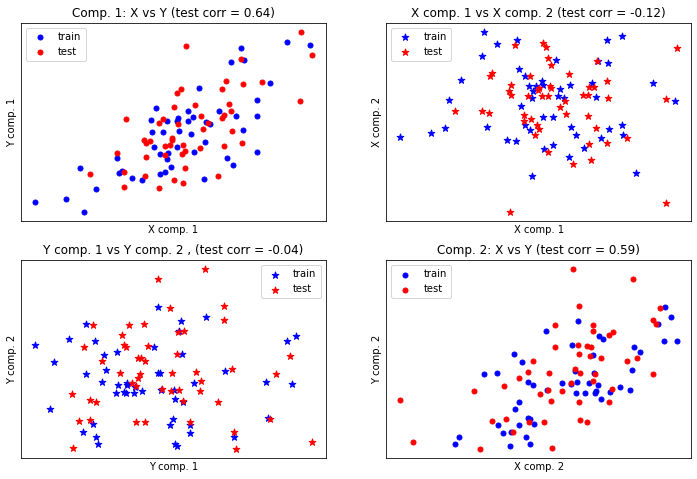

In [8]:
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

Note that in this scenario, CCA and PLSCanonical seems to give the same results. But it could not be the case on your data!


## Overfitting

We will now adress a topic you should **ALWAYS** be aware when dealing with machine learning approaches: overfitting.

Let's try to train the CCA algorithm on data where there is only noise (i.e. there is no common latent variable between X and Y). 

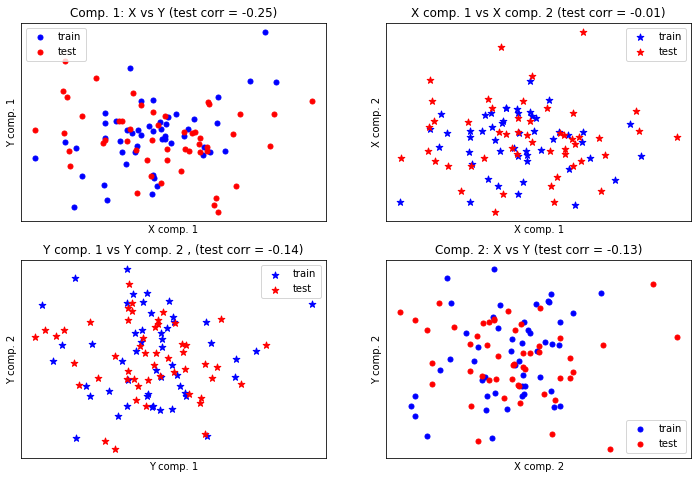

In [9]:
latents_x = np.array([l1, l1, l1, l1, l1, l1]).T
latents_y = np.array([l2, l2, l2, l2]).T

X = latents_x + np.random.normal(size=6 * n).reshape((n, 6))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))

X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = cca.transform(X_train, Y_train)
X_test_r, Y_test_r = cca.transform(X_test, Y_test)

plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

As you can see here, the correlation when comparing X and Y on the test set is negative, which is really really bad. How do you know if it's too bad? Please check the Tutorial 3 (*coming soon*) to answer this question.


## PLS Regression


The PLS Regression algorithm is more suitable when you see the PLS approach as a supervised algorithm: i.e. you want to predict Y based on X. Note that it is also possible with CCA and PLSCanonical, but PLS regression should be more efficient to predict Y.

Compare to CCA and PLS Canonical, PLS Regression is non symmetric (i.e. X and Y and not treated the same way). However, as you will see below, PLS Regression and Canonical will compute the same latent variables.

Let's first define the simulated database, based on 4 different latent variables (with only l1 and l2 common to X and Y).

In [10]:
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)
l3 = np.random.normal(size=n)
l4 = np.random.normal(size=n)

latents_x = np.array([l1, l2, l3]).T
latents_y = np.array([l1, l2, l1+l2, l4]).T

X = latents_x + np.random.normal(size=3 * n).reshape((n, 3))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))

X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

As before, we can still train the algorithm and plot the latent variables found by the model.

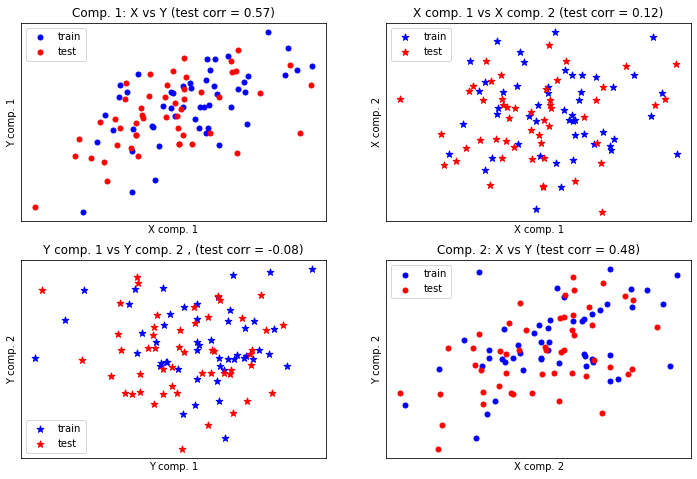

In [11]:
# PLS regression, with multivariate response, a.k.a. PLS2

pls2 = PLSRegression(n_components=2)
pls2.fit(X_train, Y_train)

X_train_r, Y_train_r = pls2.transform(X_train, Y_train)
X_test_r, Y_test_r = pls2.transform(X_test, Y_test)

plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

As we said, PLS regression is more a supervised approach and is usually used to predict Y based on X. We can thus compute the correlation score (R squared) between the true Y and the predicted Y. 

In [12]:
from sklearn.metrics import r2_score

Y_pred = pls2.predict(X_test)
r2_score(Y_test, Y_pred, multioutput='raw_values')

array([ 0.16532387,  0.22606084,  0.34104974, -0.07303853])

As expected, the higher scores obtained correpond to the one having latent variables in common within X.

Now what happen if we use PLS Canonical instead of PLS Regression?

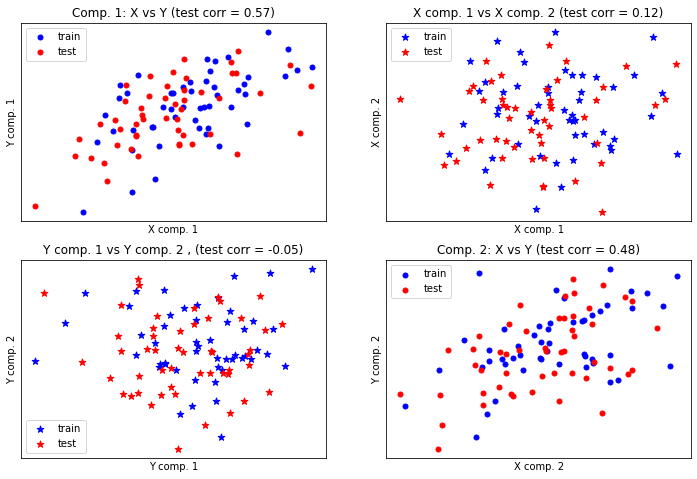

In [13]:
# PLS Canonical

plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
Y_pred = plsca.predict(X_test)

X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

In [14]:
r2_score(Y_test, Y_pred, multioutput='raw_values')

array([ 0.07718418,  0.0917961 ,  0.26295776, -0.10508033])

We observe that the same latent variables has been computed but the R2 scores are much worst with PLS Canonical.


## PLS-PM

If you have more than two blocks of variables and want to represent the relationships between them, the methods presented so far will not allow you to answer your question.

For this, you will have to use another method: Partial Least Square - Path Modeling (PLS-PM).
This method represents the relationships between matrices in the form of paths.

- **inner model:** a weight is assigned to each path to quantify the relationship between the two matrices.
- **outer model:** a weight is assigned to each variable within the blocks, and is used to compute its latent variable

Note that only one latent variable is computed per matrix, whereas in the methods presented previously, we could define the number of latent variables to be considered.

This method is extremely well documented for the library R *plspm* [here](https://www.gastonsanchez.com/PLS_Path_Modeling_with_R.pdf) and has been implemented in Python [here](https://github.com/GoogleCloudPlatform/plspm-python).

Make sure you have installed the plspm library in Python before running the codes below.

In [15]:
import pandas as pd, plspm.config as c
from plspm.plspm import Plspm
from plspm.scheme import Scheme
from plspm.mode import Mode

### Database

We will first define a database composed of 4 differents blocks: X, Y, Z, C.

In [16]:
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)
l3 = np.random.normal(size=n)

latents_x = np.array([l1, l1, l1, l1, l1, l1]).T
latents_y = np.array([-l2, -l2, -l2, l3]).T
latents_z = np.array([l3, l3, l3, l3, l3]).T
latents_c = np.array([l1, l1, l2]).T

X = latents_x + np.random.normal(size=6 * n).reshape((n, 6))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))
Z = latents_z + np.random.normal(size=5 * n).reshape((n, 5))
C = latents_c + np.random.normal(size=3 * n).reshape((n, 3))

df = pd.DataFrame(np.concatenate([X, Y, Z, C], axis=1),
                  columns=[f'x{i}' for i in range(X.shape[1])] + \
                          [f'y{i}' for i in range(Y.shape[1])] + \
                          [f'z{i}' for i in range(Z.shape[1])] + \
                          [f'c{i}' for i in range(C.shape[1])])

The idea is then to create the paths: imagine that we want to know the influence of X, Y, and Z on C.

We then create the paths X -> C, Y -> C and Z -> C, and train the model. 

In [17]:
lvs = ["X", "Y", "Z", "C"]
sat_path_matrix = pd.DataFrame(
    [[0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [1, 1, 1, 0]],
    index=lvs, columns=lvs)
config = c.Config(sat_path_matrix, scaled=False)
config.add_lv_with_columns_named("X", Mode.A, df, "x")
config.add_lv_with_columns_named("Y", Mode.A, df, "y")
config.add_lv_with_columns_named("Z", Mode.A, df, "z")
config.add_lv_with_columns_named("C", Mode.A, df, "c")
plspm_calc = Plspm(df, config, Scheme.CENTROID)

We can then print the weight attributed to each defined path. 

In [18]:
print(plspm_calc.inner_model()['C'])

   estimate  std error          t         p>|t|
X  0.773659   0.057611  13.429049  9.115657e-24
Y  0.177848   0.057674   3.083698  2.669740e-03
Z  0.029859   0.056202   0.531280  5.964521e-01


As expected, the relation between Y and C is negative. Moreover, we can see that the relation between Z and C doesn't seem significant.

Similarly, we can also have a look at the weights of the outer model (i.e. attributed to the variables of each block).

In [19]:
print(plspm_calc.outer_model())

      weight   loading  communality  redundancy
c0  0.348183  0.827817     0.685281    0.479483
c1  0.362834  0.819889     0.672218    0.470342
c2 -0.235862 -0.397521     0.158023    0.110567
x0  0.149542  0.806241     0.650024    0.000000
x1  0.149179  0.773760     0.598704    0.000000
x2  0.155372  0.791124     0.625878    0.000000
x3  0.158886  0.774308     0.599553    0.000000
x4  0.156232  0.789949     0.624020    0.000000
x5  0.132590  0.729257     0.531816    0.000000
y0 -0.302268  0.803336     0.645349    0.000000
y1 -0.185149  0.628673     0.395230    0.000000
y2 -0.382384  0.837972     0.702197    0.000000
y3 -0.234099  0.334476     0.111874    0.000000
z0 -0.030906  0.546512     0.298675    0.000000
z1  0.038583  0.651760     0.424791    0.000000
z2  0.124327  0.755166     0.570275    0.000000
z3  0.576061  0.980675     0.961724    0.000000
z4  0.078016  0.633620     0.401474    0.000000


To validate that the value of these weights is significant, you can use bootstraping.

In [20]:
plspm_calc = Plspm(df, config, Scheme.CENTROID,
                   bootstrap=True, bootstrap_iterations=50)

In [21]:
print(plspm_calc.bootstrap().paths())

        original      mean  std.error  perc.025  perc.975    t stat.
X -> C  0.753574  0.749852   0.058035  0.630770  0.837908  12.984799
Y -> C  0.263107  0.174418   0.151062 -0.283770  0.395561   1.741709
Z -> C  0.138209  0.041991   0.078825 -0.099932  0.162051   1.753360


In [22]:
print(plspm_calc.bootstrap().loading())

    original      mean  std.error  perc.025  perc.975    t stat.
x0  0.806241  0.794373   0.039590  0.716789  0.846694  20.364600
x1  0.773760  0.779418   0.051765  0.690869  0.857839  14.947466
x2  0.791124  0.778685   0.047808  0.686348  0.851448  16.547779
x3  0.774308  0.764222   0.049710  0.659908  0.854272  15.576352
x4  0.789949  0.790026   0.043834  0.692033  0.862116  18.021309
x5  0.729257  0.737038   0.050477  0.658486  0.815124  14.447355
y0  0.803336  0.302141   0.675858 -0.866234  0.944008   1.188616
y1  0.628673  0.193884   0.608788 -0.857946  0.798632   1.032664
y2  0.837972  0.383461   0.626352 -0.798288  0.898257   1.337861
y3  0.334476  0.451735   0.304217 -0.193165  0.912554   1.099465
z0  0.546512  0.484489   0.500730 -0.792286  0.886492   1.091429
z1  0.651760  0.525351   0.413137 -0.725132  0.854407   1.577590
z2  0.755166  0.537017   0.484041 -0.759027  0.872491   1.560127
z3  0.980675  0.650576   0.436532 -0.720031  0.944711   2.246516
z4  0.633620  0.507621   

As expected, we can see here that the weight Z -> C is not stable (perc.025 < 0 and perc.975>0). Same for y3.

We hope you enjoyed this tutorial! Do not hesitate to navigate through the other tutorials and give us feedback :)